In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotting_functions as pf
from scipy import sparse
from colour import Color
import math
from matplotlib import path as Path_Module
import newFFN2_functions as nFF2

In [2]:
asymm_to_theta = {
    0: 0,
    1: np.pi/4,
    2: np.pi/2,
    3: 3*np.pi/4,
    4: np.pi,
    5: 5*np.pi/4,
    6: 3*np.pi/2,
    7: 7*np.pi/4
}

In [3]:
def get_sum(vectors, nrow, ncol):
    """Returns the vector sum of two vectors, assuming same starting point = (0,0)"""
    x = 0
    y = 0
    for v in vectors:
        l = v[0]
        theta = v[1]
        x += l * np.cos(theta)
        y += l * np.sin(theta)
    l2 = np.sqrt(x**2 + y**2)
    t2 = np.arctan2(x,y)
    if t2 < 0:
        t2 += 2*np.pi
    return [l2,t2]

def get_mean(vectors, nrow, ncol):
    """Returns the mean/average vector of multiple vectors, assuming same starting point = (0,0)"""
    x = 0
    y = 0
    for v in vectors:
        l = v[0]
        theta = v[1]
        x += l * np.cos(theta)
        y += l * np.sin(theta)
    x = x/len(vectors)
    y = y/len(vectors)
    l2 = np.sqrt(x**2 + y**2)
    t2 = np.arctan2(x,y)
    if t2 < 0:
        t2 += 2*np.pi
    return [l2,t2]

def reverse_vector(vector):
    """Returns a vector with same length but opposite direction"""
    rvector = [vector[0], (vector[1] + np.pi)%(2*np.pi)]
    return rvector

In [4]:
def get_ends_EtoE(vector, iN, nrowE, ncolE):
    """Return the ends of vector starting from neuron in E layer to neuron in E layer. 
    If the given neuron sends symmetric connections, vector = [0,0], then it takes unit vectors in all directions"""
    ends = []
    l = vector[0]
    theta = vector[1]
    if l == 0 and theta == 0:
        for t in range(8):
            x = round(iN[0] + np.cos(asymm_to_theta[t]))
            y = round(iN[1] + np.sin(asymm_to_theta[t]))
            ends.append([int(x%nrowE), int(y%ncolE)])
    else:
        x = round(iN[0] + l * np.cos(theta))
        y = round(iN[1] + l * np.sin(theta))
        ends.append([int(x%nrowE), int(y%ncolE)])
    return ends

def get_ends_EtoI(vector, iN, nrowE, ncolE, nrowI, ncolI):
    """Return the ends of vector starting from neuron in E layer to neuron in I layer. 
    If the given neuron sends symmetric connections, vector = [0,0], then it takes unit vectors in all directions"""
    ends = []
    c = nrowE / nrowI
    iNI = [round(iN[0]/c), round(iN[1]/c)]
    l = vector[0]/c
    theta = vector[1]
    if l == 0 and theta == 0:
        for t in range(8):
            x = round(iNI[0] + np.cos(asymm_to_theta[t]))
            y = round(iNI[1] + np.sin(asymm_to_theta[t]))
            ends.append([int(x%nrowI), int(y%ncolI)])
    else:
        x = round(iNI[0] + l * np.cos(theta))
        y = round(iNI[1] + l * np.sin(theta))
        ends.append([int(x%nrowI), int(y%ncolI)])    
    return ends

def get_ends_ItoE(vector, iN, nrowE, ncolE, nrowI, ncolI):
    """Return the ends of vector starting from neuron in I layer to neuron in E layer. 
    If the given neuron sends symmetric connections, vector = [0,0], then it takes unit vectors in all directions"""
    ends = []
    c = nrowI / nrowE
    iNE = [round(iN[0]/c), round(iN[1]/c)]
    l = vector[0]/c
    theta = vector[1]
    if l == 0 and theta == 0:
        for t in range(8):
            x = round(iNE[0] + np.cos(asymm_to_theta[t]))
            y = round(iNE[1] + np.sin(asymm_to_theta[t]))
            ends.append([int(x%nrowE), int(y%ncolE)])
    else:
        x = round(iNE[0] + l * np.cos(theta))
        y = round(iNE[1] + l * np.sin(theta))
        ends.append([int(x%nrowE), int(y%ncolE)])
    return ends  

def get_ends_ItoI(vector, iN, nrowI, ncolI):
    """Return the ends of vector starting from neuron in I layer to neuron in I layer. 
    If the given neuron sends symmetric connections, vector = [0,0], then it takes unit vectors in all directions"""
    ends = []
    l = vector[0]
    theta = vector[1]
    if l == 0 and theta == 0:
        for t in range(8):
            x = round(iN[0] + np.cos(asymm_to_theta[t]))
            y = round(iN[1] + np.sin(asymm_to_theta[t]))
            ends.append([int(x%nrowI), int(y%ncolI)])
    else:
        x = round(iN[0] + l * np.cos(theta))
        y = round(iN[1] + l * np.sin(theta))
        ends.append([int(x%nrowI), int(y%ncolI)])
    return ends

def get_net_vector_from_ends_EtoE(Eends, eN, nrowE, ncolE):
    """Return the net vector from initial E neuron to multiple ending E neurons"""
    xN, yN = eN[0], eN[1]
    vectors = []
    for _eN in Eends:
        dx1 = _eN[0] - xN
        dy1 = _eN[1] - yN
        dx = [dx1, (np.abs(dx1)-nrowE)*np.sign(dx1)][np.argmin([np.abs(dx1), nrowE-np.abs(dx1)])]
        dy = [dy1, (np.abs(dy1)-ncolE)*np.sign(dy1)][np.argmin([np.abs(dy1), nrowE-np.abs(dy1)])]
        t = np.arctan2(dy,dx)
        if t < 0:
            t += 2*np.pi
        l = np.sqrt(dx**2 + dy**2)
        vectors.append([l,t])
    vector = get_mean(vectors, nrowE, ncolE)          
    return vector

In [5]:
def init_grid(nrowE, ncolE):
    fig, ax = plt.subplots()
    ax.set_aspect("equal")
    ax.set_xlabel("Neuron grid x-axis")
    ax.set_ylabel("Neuron grid y-axis")
    ax.set_xlim([0,nrowE])
    ax.set_ylim([0,ncolE])
    return fig, ax

def init_grid_ax(nrowE, ncolE, ax):
    ax.set_aspect("equal")
    ax.set_xlabel("Neuron grid x-axis")
    ax.set_ylabel("Neuron grid y-axis")
    ax.set_xlim([0,nrowE])
    ax.set_ylim([0,ncolE])
    return

def get_neighbours(iN, w, nrow, ncol, ignore):
    list_neighbours = []
    w = w/2
    for x in range(int(iN[0]-w), int(iN[0]+w), 1):
        for y in range(int(iN[1]-w), int(iN[1]+w),1):
            if x not in ignore and y not in ignore:
                list_neighbours.append([x%nrow,y%ncol])
    return list_neighbours

In [6]:
# 1st order connections functions

def get_EE_vectors(landscape, asymm, nrowE, ncolE, nrowI, ncolI):
    """hsa"""
    all_vectors = np.zeros((nrowE, ncolE, 2))
    if asymm == 'EE':
        for _xN in range(nrowE):
            for _yN in range(ncolE):
                all_vectors[_xN, _yN, :] = np.array([1, asymm_to_theta[landscape[_xN, _yN]]])
    return all_vectors

In [7]:
# 2nd order connections functions 

def get_EEE_vectors(landscape, asymm, nrowE, ncolE, nrowI, ncolI):
    """Get vectors of 2nd order excitatory effects from E to E to E neurons"""
    all_vectors = np.zeros((nrowE, ncolE, 2))
    vEE, vEE2 = [0,0], [0,0]
    for _xN in range(nrowE):
        for _yN in range(ncolE):
            if asymm == 'EE':
                vEE = [1, asymm_to_theta[landscape[_xN, _yN]]]
                
            E_ends1 = get_ends_EtoE(vEE, [_xN, _yN], nrowE, ncolE)

            E_ends2 = []
            for _eN in E_ends1:
                if asymm == 'EE':
                    vEE2 = [1, asymm_to_theta[landscape[_eN[0], _eN[1]]]]
                E_ends2 += get_ends_EtoE(vEE2, _eN, nrowE, ncolE)

            #vE2 = get_net_vector_from_ends_EtoE(E_ends2, [_xN, _yN], nrowE, ncolE) 
            all_vectors[_xN, _yN, :] = np.array(get_net_vector_from_ends_EtoE(E_ends2, [_xN, _yN], nrowE, ncolE))
    all_vectors[:,:, 0] = all_vectors[:,:, 0] * 1
    return all_vectors

def get_EIE_vectors(landscape, asymm, nrowE, ncolE, nrowI, ncolI):
    """Get vectors of 2nd order inhibitory effects from E to I to E neurons"""
    all_vectors = np.zeros((nrowE, ncolE, 2))
    vEI, vIE = [0,0], [0,0]
    for _xN in range(nrowE):
        for _yN in range(ncolE):
            if asymm == 'EI':
                vEI = [1, asymm_to_theta[landscape[_xN, _yN]]]
                
            I_ends1 = get_ends_EtoI(vEI, [_xN, _yN], nrowE, ncolE, nrowI, ncolI)
            
            E_ends2 = []
            for _iN in I_ends1:
                if asymm == 'IE':
                    vIE = [1, asymm_to_theta[landscape[_iN[0], _iN[1]]]]
                E_ends2 += get_ends_ItoE(vIE, _iN, nrowE, ncolE, nrowI, ncolI)

            #vE2 = get_net_vector_from_ends_EtoE(E_ends2, [_xN, _yN], nrowE, ncolE) 
            all_vectors[_xN, _yN, :] = np.array(get_net_vector_from_ends_EtoE(E_ends2, [_xN, _yN], nrowE, ncolE))
    all_vectors[:,:, 0] = all_vectors[:,:, 0] * 1      
    return all_vectors

In [8]:
# 3rd order connections functions

def get_EEEE_vectors(landscape, asymm, nrowE, ncolE, nrowI, ncolI):
    """Get vectors of 3rd order excitatory effects from E to E to E to E neurons"""
    all_vectors = np.zeros((nrowE, ncolE, 2))
    vEE, vEE2, vEE3 = [0,0], [0,0], [0,0]
    for _xN in range(nrowE):
        for _yN in range(ncolE):
            
            if asymm == 'EE':
                vEE = [1, asymm_to_theta[landscape[_xN, _yN]]]            
            E_ends1 = get_ends_EtoE(vEE, [_xN, _yN], nrowE, ncolE)

            E_ends2 = []
            for _eN in E_ends1:
                if asymm == 'EE':
                    vEE2 = [1, asymm_to_theta[landscape[_eN[0], _eN[1]]]]
                E_ends2 += get_ends_EtoE(vEE2, _eN, nrowE, ncolE)
                
            E_ends3 = []
            for _eN in E_ends2:
                if asymm == 'EE':
                    vEE3 = [1, asymm_to_theta[landscape[_eN[0], _eN[1]]]]
                E_ends3 += get_ends_EtoE(vEE3, _eN, nrowE, ncolE)

            #vE2 = get_net_vector_from_ends_EtoE(E_ends2, [_xN, _yN], nrowE, ncolE) 
            all_vectors[_xN, _yN, :] = np.array(get_net_vector_from_ends_EtoE(E_ends3, [_xN, _yN], nrowE, ncolE))
    all_vectors[:,:, 0] = all_vectors[:,:, 0] * 1      
    del([vEE, vEE2, vEE3, E_ends1, E_ends2, E_ends3])           
    return all_vectors

def get_EIIE_vectors(landscape, asymm, nrowE, ncolE, nrowI, ncolI):
    """Get vectors of 3rd order excitatory effects from E to I to I to E neurons"""
    all_vectors = np.zeros((nrowE, ncolE, 2))
    vEI, vII, vIE = [0,0], [0,0], [0,0]
    for _xN in range(nrowE):
        for _yN in range(ncolE):
            
            if asymm == 'EI':
                vEI = [1, asymm_to_theta[landscape[_xN, _yN]]]
            I_ends1 = get_ends_EtoI(vEI, [_xN, _yN], nrowE, ncolE, nrowI, ncolI)

            I_ends2 = []
            for _iN in I_ends1:
                if asymm == 'II':
                    vII = [1, asymm_to_theta[landscape[_iN[0], _iN[1]]]]
                I_ends2 += get_ends_ItoI(vII, _iN, nrowI, ncolI)
                
            E_ends3 = []
            for _iN in I_ends2:
                if asymm == 'IE':
                    vIE = [1, asymm_to_theta[landscape[_iN[0], _iN[1]]]]
                E_ends3 += get_ends_ItoE(vIE, _iN, nrowE, ncolE, nrowI, ncolI)

            #vE2 = get_net_vector_from_ends_EtoE(E_ends2, [_xN, _yN], nrowE, ncolE) 
            all_vectors[_xN, _yN, :] = np.array(get_net_vector_from_ends_EtoE(E_ends3, [_xN, _yN], nrowE, ncolE))
    all_vectors[:,:, 0] = all_vectors[:,:, 0] * 1     
    del([vEI, vII, vIE, I_ends1, I_ends2, E_ends3])       
    return all_vectors

def get_EIEE_vectors(landscape, asymm, nrowE, ncolE, nrowI, ncolI):
    """Get vectors of 3rd order inhibitory effects from E to I to E to E neurons"""
    all_vectors = np.zeros((nrowE, ncolE, 2))
    vEI, vIE, vEE = [0,0], [0,0], [0,0]
    for _xN in range(nrowE):
        for _yN in range(ncolE):
            
            if asymm == 'EI':
                vEI = [1, asymm_to_theta[landscape[_xN, _yN]]]
            I_ends1 = get_ends_EtoI(vEI, [_xN, _yN], nrowE, ncolE, nrowI, ncolI)

            E_ends2 = []
            for _iN in I_ends1:
                if asymm == 'IE':
                    vIE = [1, asymm_to_theta[landscape[_iN[0], _iN[1]]]]
                E_ends2 += get_ends_ItoE(vIE, _iN, nrowE, ncolE, nrowI, ncolI)
                
            E_ends3 = []
            for _eN in E_ends2:
                if asymm == 'EE':
                    vEE = [1, asymm_to_theta[landscape[_eN[0], _eN[1]]]]
                E_ends3 += get_ends_EtoE(vEE, _eN, nrowE, ncolE)

            #vE2 = get_net_vector_from_ends_EtoE(E_ends2, [_xN, _yN], nrowE, ncolE) 
            all_vectors[_xN, _yN, :] = np.array(get_net_vector_from_ends_EtoE(E_ends3, [_xN, _yN], nrowE, ncolE))
    all_vectors[:,:, 0] = all_vectors[:,:, 0] * 1
    del([vEI, vEE, vIE, I_ends1, E_ends2, E_ends3])       
    return all_vectors

def get_EEIE_vectors(landscape, asymm, nrowE, ncolE, nrowI, ncolI):
    """Get vectors of 3rd order inhibitory effects from E to E to I to E neurons"""
    all_vectors = np.zeros((nrowE, ncolE, 2))
    vEE, vEI, vIE = [0,0], [0,0], [0,0]
    for _xN in range(nrowE):
        for _yN in range(ncolE):
            
            if asymm == 'EE':
                vEE = [1, asymm_to_theta[landscape[_xN, _yN]]]
            E_ends1 = get_ends_EtoE(vEE, [_xN, _yN], nrowE, ncolE)

            I_ends2 = []
            for _eN in E_ends1:
                if asymm == 'EI':
                    vEI = [1, asymm_to_theta[landscape[_eN[0], _eN[1]]]]
                I_ends2 += get_ends_EtoI(vEI, _eN, nrowE, ncolE, nrowI, ncolI)
                
            E_ends3 = []
            for _iN in I_ends2:
                if asymm == 'IE':
                    vIE = [1, asymm_to_theta[landscape[_iN[0], _iN[1]]]]
                E_ends3 += get_ends_ItoE(vIE, _iN, nrowE, ncolE, nrowI, ncolI)

            #vE2 = get_net_vector_from_ends_EtoE(E_ends2, [_xN, _yN], nrowE, ncolE) 
            all_vectors[_xN, _yN, :] = np.array(get_net_vector_from_ends_EtoE(E_ends3, [_xN, _yN], nrowE, ncolE))
    all_vectors[:,:, 0] = all_vectors[:,:, 0] * 1
    del([vEE, vEI, vIE, E_ends1, I_ends2, E_ends3])       
    return all_vectors

In [9]:
def get_points_in_circle(iN, w):
    cx = iN[0]
    cy = iN[1]
    r = w/2
    
    # create circle path
    dth = np.arange(0,2*np.pi,0.01)
    x_coor = cx + r*np.cos(dth)
    y_coor = cy + r*np.sin(dth)
    circle_path1 = np.vstack((x_coor, y_coor)).T.tolist()
    #print(circle_path1[:5])
    circle_path = Path_Module.Path(circle_path1)
    
    # contains points
    
    r1 = int(w/2) + 5
    csq_xs = np.arange(cx-r1, cx+r1)
    csq_ys = np.arange(cy-r1, cy+r1)
    all_points = []
    for i in range(len(csq_xs)):
        for j in range(len(csq_ys)):
            all_points.append((csq_xs[i], csq_ys[j]))
    
    if_in = circle_path.contains_points(all_points)
    in_sector = np.array(all_points)[if_in] % 120
    return in_sector

def get_points_in_ellipse(iN, maj_ax, min_ax, theta):
    el_p = get_ellipse_points(iN, maj_ax, min_ax, theta).T.tolist()
    ellipse_path = Path_Module.Path(el_p)
    cx = iN[0]
    cy = iN[1]
    # contains points  
    r1 = maj_ax + 5
    csq_xs = np.arange(cx-r1, cx+r1)
    csq_ys = np.arange(cy-r1, cy+r1)
    all_points = []
    for i in range(len(csq_xs)):
        for j in range(len(csq_ys)):
            all_points.append((csq_xs[i], csq_ys[j]))
    
    if_in = ellipse_path.contains_points(all_points)
    in_sector = np.array(all_points)[if_in] % 120
    #print(np.shape(all_points))
    return in_sector
   

def get_surround_avg(iN, all_vec, area_typ, param, theta):
    
    if area_typ == 'circle':
        [w, dc_off, dc_scale] = param
        c = np.array(get_points_in_circle(iN, w))
    elif area_typ == 'ellipse':
        [major_axis, minor_axis, dc_off, dc_scale] = param
        c = np.array(get_points_in_ellipse(iN, major_axis, minor_axis, theta))
    
    vecs = all_vec[c[:,0],c[:,1],:]
    
    # Weight the vectors or not
    dc = 1 / (np.sqrt((c[:,0] - iN[0])**2 + (c[:,1] - iN[1])**2) + dc_off)
    #dc = 1
    
    # First method - take mean of length and theta directly and then combine
    #l = np.sum(vecs[:,0] * dc) / np.sum(dc)
    #theta = np.mean(vecs[:,1] * 1)
    
    # Second method - take vector sum by calculating projections of each vector
    vecs[:,0] = vecs[:,0] * dc #/ np.sum(dc)
    [l, theta] = get_mean(vecs.tolist(), 120,120)
    
    return [l, theta]

def distance_scale(vector, fN, iN, params):
    [dc_off, dc_scale] = params
    d = np.sqrt((fN[1] - iN[1])**2 + (fN[0] - iN[0])**2)
    l_new = vector[0] * dc_scale / (d + dc_off)
    theta_new = vector[1]
    return [l_new, theta_new]
    

In [10]:
def get_ellipse_points(iN, a, b, th):
    dth = np.arange(0, 2*np.pi, 0.01)
    cx = iN[0]
    cy = iN[1]
    th_0 = th
    rotation_matrix = np.array([[np.cos(th_0), -np.sin(th_0)], [np.sin(th_0), np.cos(th_0)]])
    
    x = a * np.cos(dth)
    y = b * np.sin(dth)
    oc = np.vstack((x,y))

    nc = np.dot(rotation_matrix, oc)
    ncx = (nc[0,:] + cx).astype(float)
    ncy = (nc[1,:] + cy).astype(float)

    #plt.plot(ncx, ncy)
    #plt.plot([cx],[cy], 'rx')
    
    return np.vstack((ncx, ncy))

In [11]:
def arrange_FR_on_grid_seq(ts, ids, t_start, t_end, t_step, ax, c, e):
    FR = pf.get_FR_time(ts, ids, 14400, t_step, t_start, t_end)    
    threshold = np.max(FR)* 0.1
    n_steps = np.shape(FR)[1]
    cm = list(Color(c[0]).range_to(Color(c[1]), int(n_steps)))
    for j in range(n_steps):
        n_firing = np.where(FR[:,j] > threshold)[0]
        ix, iy = np.array(n_firing) % 120, np.array(n_firing) // 120
        if len(n_firing) > 0:
            c = [cm[j].rgb] * len(n_firing)
            if e == True:
                ax.scatter(ix, iy, marker='.', c=c, alpha=0.4)
            else:
                ax.scatter(ix, iy, marker='.', c=c, alpha=0.4)               
    return FR

In [22]:
from sklearn.cluster import DBSCAN

def get_distance(FF_path, activity_path):
    lF = np.shape(FF_path)[0]
    lA = np.shape(activity_path)[0]
    print([np.shape(FF_path), np.shape(activity_path)])
    distances = np.zeros((lF, lA))
    for _fp in range(lF):
        for _ap in range(lA):
            xFF, yFF = FF_path[_fp,0], FF_path[_fp,1]
            xAC, yAC = activity_path[_ap,0], activity_path[_ap,1]
            distances[_fp, _ap] = np.sqrt((xFF - xAC)**2 + (yFF - yAC)**2)
            del([xFF, yFF, xAC, yAC])
    min_FF_to_AC = np.min(distances, axis=1)
    min_AC_to_FF = np.min(distances, axis=0)
    d = np.min([np.mean(min_FF_to_AC), np.mean(min_AC_to_FF)])
    del([lF, lA, distances, min_FF_to_AC, min_AC_to_FF])
    return d

def get_centroids_activity_path(FR_time, nrowE, ncolE, iN):
    centroids = [] #np.zeros((np.shape(FR_time)[1], 2))
    len_from_iN = np.zeros(np.shape(FR_time)[1])
    threshold = 0.5 * np.mean(FR_time)
    for _i in range(np.shape(FR_time)[1]):
        _fN = np.where(FR_time[:, _i] > threshold)[0]
        if len(_fN) < 10:
            #centroids[_i, :] = np.inf
            continue
        cxN, cyN = _fN // nrowE, _fN % ncolE
        nclus, labels = get_nclusters(cxN, cyN)
        #print(nclus)
        if nclus < 1:
            #centroids[_i, :] = np.inf
            continue
        for _c in range(nclus):
            clusters = np.where(labels == _c)
            _cxN, _cyN = cxN[clusters], cyN[clusters]
            #centroids[_i, :] = np.array([np.mean(_cxN), np.mean(_cyN)])
            centroids.append([np.mean(_cxN), np.mean(_cyN)])
            len_from_iN[_i] = np.sqrt((np.mean(_cxN) - iN[0])**2 + (np.mean(_cyN) - iN[1])**2)
            del([clusters, _cxN, _cyN])
        del([labels, _fN, cxN, cyN])
    if len(np.where(len_from_iN > 10)[0]) < 10:
        out = False
    else:
        out = True
    centroids = np.array(centroids)
    return centroids, out

def get_nclusters(xs, ys):
    data = np.vstack((xs, ys)).T
    db = DBSCAN(eps=3, min_samples=10).fit(data)
    labels = db.labels_
    nclusters = np.max(labels) + 1
    if nclusters != 0:
        return nclusters, labels
    else:
        return nclusters, []
    

In [13]:
# Load the landscape

nrowE = ncolE = 120
nrowI = ncolI = 60
nE = nrowE * ncolE
nI = nrowI * ncolI
nN = nE + nI

# --- asymmetry parameters
asymm = 'EE'
landscape_type = 'perlinuniform'
landscape_size = 3
base = 0
[pEE, pEI, pIE, pII] = [0.05, 0.05, 0.05, 0.05]
[stdEE, stdEI, stdIE, stdII] = [7, 9, 7, 9]

# --- read the landscape file
address = '/shreya/AM_all/'
vec_address = '/shreya/vec_all/'
fname = 'size{}_{}_perlinuniform_std4.0-6.0-4.0-6.0_p0.05-0.05-0.05-0.05_shift1.0_base{}landscape.npz'.format(landscape_size, asymm, base)
#fname = 'size{}_{}_perlinuniform_std7.0-9.0-7.0-9.0_p0.05-0.05-0.05-0.05_shift1.0landscape.npz'.format(landscape_size, asymm)
#fname = 'size3_EE_perlinuniform_std7.0-9.0-7.0-9.0_p0.05-0.05-0.05-0.05_alpha0.2_sep2.0_width10.0_landscape.npz'

landscape = sparse.load_npz(address + fname).toarray()
nrowL = int(np.sqrt(np.size(landscape)))
landscape = landscape.reshape((nrowL, nrowL))

fname = '{}size{}_{}_perlinuniform_std4.0-6.0-4.0-6.0_p0.05-0.05-0.05-0.05_shift1.0_base{}landscape.npz'
fname2 = '{}size{}_{}_perlinuniform_std4.0-6.0-4.0-6.0_p0.05-0.05-0.05-0.05_shift1.0_base{}_{}.npy'
vEE_all, vEEE_all, vEIE_all, vEEEE_all, vEEIE_all, vEIEE_all, vEIIE_all = nFF2.read_or_get_vec(fname, fname2, address, vec_address, landscape_size, asymm, base, [nrowE, ncolE, nrowI, ncolI])

First order connections read.
Second order connections read.
Second order connections read.
Third order connections read.
Third order connections read.
Third order connections read.
Third order connections read.


In [24]:
# 1st order vectors
vEE_all = get_EE_vectors(landscape, asymm, nrowE, ncolE, nrowI, ncolI)

In [25]:
# 2nd order vectors
vEEE_all = get_EEE_vectors(landscape, asymm, nrowE, ncolE, nrowI, ncolI)
vEIE_all = get_EIE_vectors(landscape, asymm, nrowE, ncolE, nrowI, ncolI)

In [26]:
# 3rd order vectors
vEEEE_all = get_EEEE_vectors(landscape, asymm, nrowE, ncolE, nrowI, ncolI)
vEIIE_all = get_EIIE_vectors(landscape, asymm, nrowE, ncolE, nrowI, ncolI)
vEIEE_all = get_EIEE_vectors(landscape, asymm, nrowE, ncolE, nrowI, ncolI)
vEEIE_all = get_EEIE_vectors(landscape, asymm, nrowE, ncolE, nrowI, ncolI)

In [34]:
addressL = '/shreya/AM_all/'
fname = '{}size{}_{}_perlinuniform_std4.0-6.0-4.0-6.0_p0.05-0.05-0.05-0.05_shift1.0_base{}landscape.npz'
fname2 = '{}size{}_{}_perlinuniform_std4.0-6.0-4.0-6.0_p0.05-0.05-0.05-0.05_shift1.0_base{}_{}.npy'
vEE_all2, vEEE_all2, vEIE_all2, vEEEE_all2, vEEIE_all2, vEIEE_all2, vEIIE_all2 = nFF2.read_or_get_vec(fname, fname2, addressL, vec_address, landscape_size, asymm, base, [nrowE, ncolE, nrowI, ncolI])

First order connections read.
Second order connections read.
Second order connections read.
Third order connections read.
Third order connections read.
Third order connections read.
Third order connections read.


In [35]:
print(np.nonzero(vEE_all - vEE_all2))
print(np.nonzero(vEEE_all - vEEE_all2))
print(np.nonzero(vEIE_all - vEIE_all2))
print(np.nonzero(vEEEE_all - vEEEE_all2))
print(np.nonzero(vEEIE_all - vEEIE_all2))
print(np.nonzero(vEIEE_all - vEIEE_all2))
print(np.nonzero(vEIIE_all - vEIIE_all2))

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))


[30, 30]
/shreya/data/EI_dynamic_input_EE/EI_EE_size3_std7-9-7-9_g8g22_J5_nmbE200I200p200_w10_a0.5_sep2_constantplace_30-30_base0/
Done.
[(501, 2), (657, 2)]
5.859444290307473
[30, 30]
Done.
[(501, 2), (657, 2)]
14.840398655774894
[30, 30]
loop found at step 21, choosing another neuron in neighbourhood
loop found at step 22, choosing another neuron in neighbourhood
loop found at step 23, choosing another neuron in neighbourhood
loop found at step 42, choosing another neuron in neighbourhood
loop found at step 43, choosing another neuron in neighbourhood
loop found at step 114, choosing another neuron in neighbourhood
loop found at step 116, choosing another neuron in neighbourhood
loop found at step 134, choosing another neuron in neighbourhood
loop found at step 136, choosing another neuron in neighbourhood
loop found at step 161, choosing another neuron in neighbourhood
loop found at step 162, choosing another neuron in neighbourhood
loop found at step 197, choosing another neuron in

loop found at step 442, choosing another neuron in neighbourhood
loop found at step 443, choosing another neuron in neighbourhood
loop found at step 462, choosing another neuron in neighbourhood
loop found at step 463, choosing another neuron in neighbourhood
loop found at step 482, choosing another neuron in neighbourhood
loop found at step 483, choosing another neuron in neighbourhood
Done.
[(501, 2), (657, 2)]
27.34650144633587
[30, 30]
loop found at step 21, choosing another neuron in neighbourhood
loop found at step 22, choosing another neuron in neighbourhood
loop found at step 23, choosing another neuron in neighbourhood
loop found at step 41, choosing another neuron in neighbourhood
loop found at step 42, choosing another neuron in neighbourhood
loop found at step 43, choosing another neuron in neighbourhood
loop found at step 62, choosing another neuron in neighbourhood
loop found at step 63, choosing another neuron in neighbourhood
loop found at step 82, choosing another neur

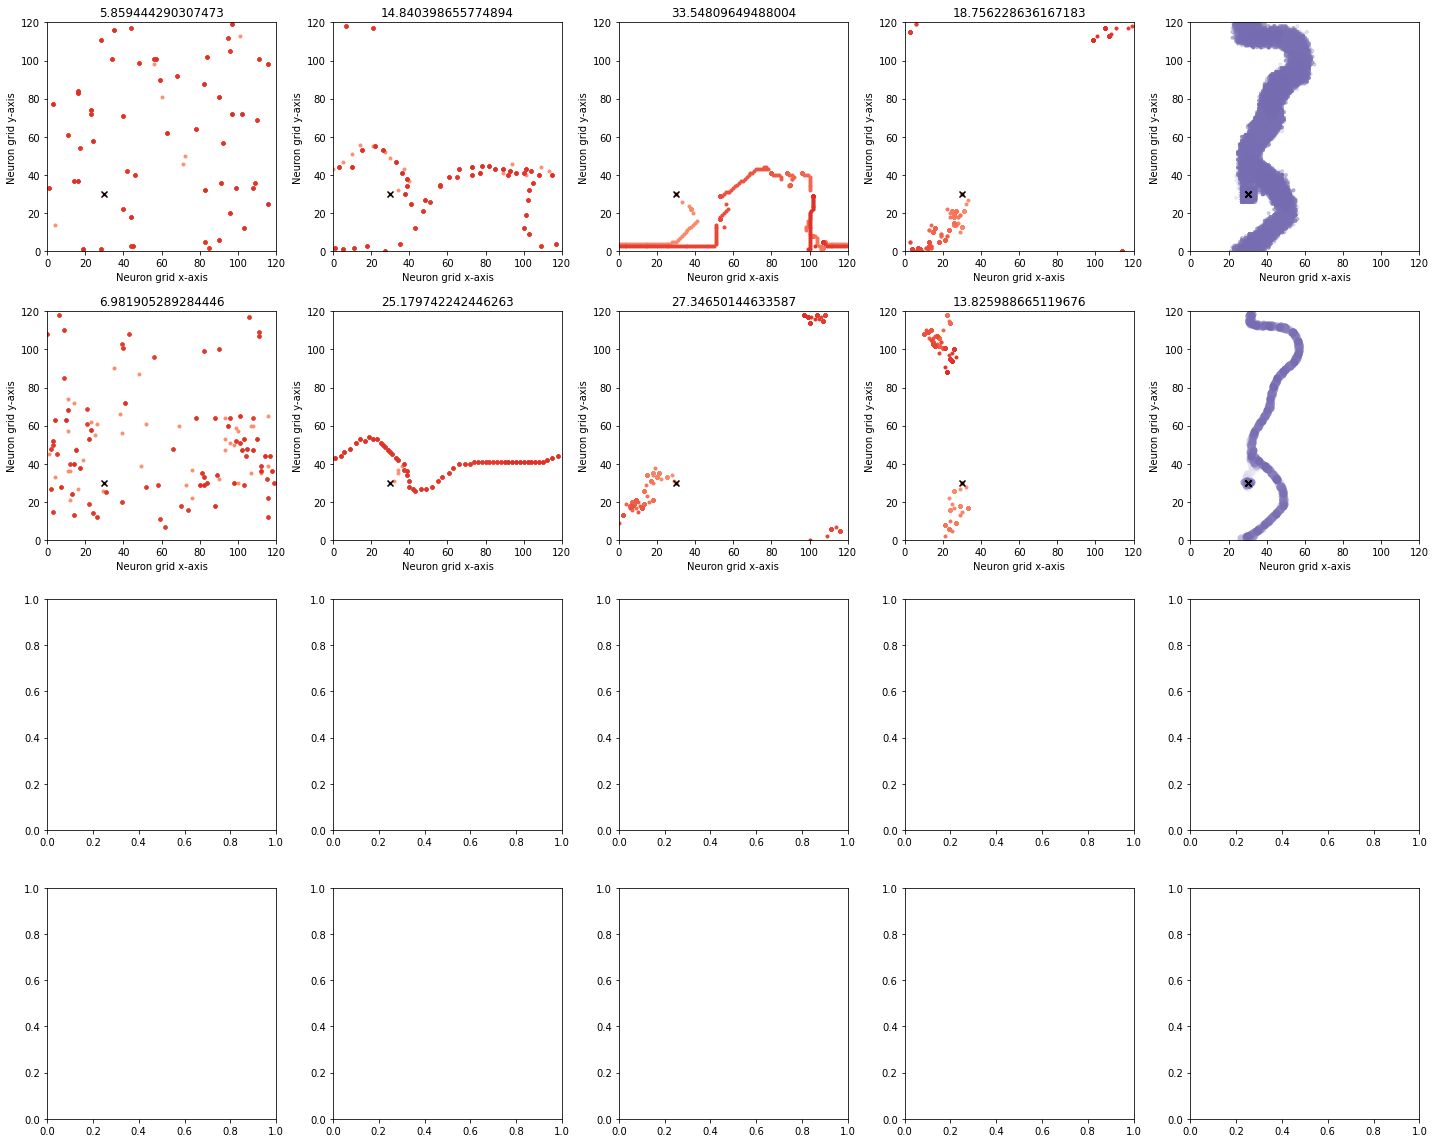

In [22]:
# Calculate FFN - one neuron + area, 1st, 2nd and 3rd order excitatory connections
# testing params script

# --- choose starting point

#start_N_all = [[30,30],[30,60],[30,90],[60,30],[60,60],[60,90],[90,30],[90,60],[90,90]]
#start_N_all = [[15,15], [15,45], [15,75], [15,105], [45,15], [45,45], [45,75], [45,105], [75,15], [75,45], [75,75], [75,105], [105,15], [105,45], [105,75], [105,105]]
start_N_all = [[30,30]]

at = 1
area_typ = 'ellipse'

n_steps = 500
dc_scale = 1
wmin = 3

path_label = ['initial','final']
fig, ax = plt.subplots(4,5, figsize=[20,16])
dist_all = np.zeros((4,4))

for i1, wmaj in enumerate([10,15]): #range that works normally - 8 to 14
    for i2, dc_off in enumerate([0.01]):
        for i3, dc_scale in enumerate([10,1,0.1,0.01]):
            for sN,start_N in enumerate(start_N_all):

                cm = [list(Color("#efedf5").range_to(Color("#756bb1"), int(n_steps + 1))), list(Color("#fc9272").range_to(Color("#de2d26"), int(n_steps + 1)))]

                for at,area_typ in enumerate(['circle']):
                    
                    print(start_N)
                    
                    sn = i1
                    sn2 = i3
                                        
                    """
                    init_grid_ax(nrowE, ncolE, ax[sn,2*at])
                    for j,p in enumerate(path):
                        ax[sn,2*at].scatter(p[1], p[0], c=[cm[1][j].rgb], marker='.')            
                    ax[sn,2*at].scatter(path[0][1], path[0][0], c='black', marker='x')
                    """
                    if sn == 0 and sn2 == 0:
                        address = '/shreya/data/EI_dynamic_input_EE/EI_EE_size3_std7-9-7-9_g8g22_J5_nmbE200I200p200_w10_a0.5_sep2_constantplace_{}-{}_base0/'.format(start_N[1], start_N[0])
                        #address = '/shreya/data/EI_dynamic_input_{}/EI_{}_poke2_size3_std4-6-4-6_g8_J10_nmbE290I290p700_base{}_{}-{}-8_trial{}/'.format(asymm, asymm, base, start_N[1], start_N[0], 0)            
                        c = ["#efedf5", "#756bb1"]
                        e = True
                        init_grid_ax(nrowE, ncolE, ax[sn,2*at+1])
                        print(address)
                        ts, ids = pf.get_spiketimes(address, 4)
                        idx = ids < 14401
                        tsE, idsE = ts[idx], ids[idx]
                        init_grid_ax(nrowE, ncolE, ax[0,4])
                        FR_time = arrange_FR_on_grid_seq(tsE, idsE, 200.,np.max(tsE),10., ax[0, 4], c, e)
                        del([ts, ids, tsE, idsE, idx])

                        activity_path, goes_out = get_centroids_activity_path(FR_time, nrowE, ncolE, start_N)
                        cm1 = list(Color("#efedf5").range_to(Color("#756bb1"), int(np.shape(activity_path)[0] + 1)))

                        if goes_out == False:
                            print("Activity does not go out!")
                            continue


                        init_grid_ax(nrowE, ncolE, ax[1,4])
                        for j,p in enumerate(activity_path):
                            if j == 0:
                                ax[1,4].scatter(p[1], p[0], c=[cm1[j].rgb], marker='o',s=50, label=path_label[0]) 
                            elif j == len(activity_path)-1:
                                ax[1,4].scatter(p[1], p[0], c=[cm1[j].rgb], marker='o',s=50, label=path_label[1]) 
                            else:
                                ax[1,4].scatter(p[1], p[0], c=[cm1[j].rgb], marker='o',s=50)

                        
                    
                    path = [start_N]
                    
                    # initial theta
                    theta = np.mean(vEE_all[(start_N[0]-4)%nrowE:(start_N[0]+4)%nrowE, (start_N[1]-4)%nrowE:(start_N[1]+4)%nrowE, 1])
                    
                    for i in range(n_steps):
            
                        #Evector1 = exc_vectors[start_N[0], start_N[1],:].tolist()
                        #params = [wmaj, wmin, dc_off, dc_scale]
                        #params = [w, dc_off, dc_scale]
                        #Evector = get_surround_avg(start_N, exc_vectors, area_typ, params, theta)   
                        
                        if area_typ == 'circle':
                            surround_points = get_points_in_circle(start_N, wmaj)
                        elif area_typ == 'ellipse':
                            surround_points = get_points_in_ellipse(start_N, wmaj, wmin, theta)

                        all_vE = []
                        #print(np.shape(surround_points))
                        for _i in range(np.shape(surround_points)[0]):
                            _xsn, _ysn = surround_points[_i, 0], surround_points[_i, 1]
                            all_vec_p = [vEE_all[_xsn, _ysn, :], vEEE_all[_xsn, _ysn, :], reverse_vector(vEIE_all[_xsn, _ysn, :]), vEEEE_all[_xsn, _ysn, :], vEIIE_all[_xsn, _ysn, :], reverse_vector(vEIEE_all[_xsn, _ysn, :]), reverse_vector(vEEIE_all[_xsn, _ysn, :])]
                            net_vE = get_sum(all_vec_p, nrowE, ncolE)
                            #net_vE = get_sum([vEE_all[_xsn, _ysn, :], vEEE_all[_xsn, _ysn, :], reverse_vector(vEIE_all[_xsn, _ysn, :])], nrowE, ncolE)
                            dc = dc_scale / (np.sqrt((start_N[0] - _xsn)**2 + (start_N[1] - _ysn)**2) + dc_off)
                            #dc = 1
                            l_scale = net_vE[0] * dc
                            net_vE = [l_scale, net_vE[1]]
                            all_vE.append(net_vE)
                        net_vE_all = get_mean(all_vE, nrowE, ncolE)
                        [start_N] = nFF2.get_ends_EtoE(net_vE_all, start_N, nrowE, ncolE)        
                        #EIvector = get_sum(EIvectors, nrowE, ncolE)
                        if area_typ == 'ellipse':
                            theta = get_sum([[3,theta], [1,net_vE_all[1]]], nrowE, ncolE)
                            theta = theta[1]
                                        
                        #start_N = get_ends([EIvector], start_N, nrowE, ncolE)[0]
                        last_path = path[-20:]
                        last_N = []
                        for lN in last_path:
                            last_N += lN
                        if i > 20 and len(np.unique(last_N)) < 6:
                            print("loop found at step {}, choosing another neuron in neighbourhood".format(i))
                            sample_list = get_neighbours(start_N, 8, nrowE, ncolE, last_N)
                            start_N = sample_list[np.random.choice(len(sample_list))]
                        
                        path.append(start_N)
                                
                    print("Done.")

                    init_grid_ax(nrowE, ncolE, ax[sn,sn2])
                    for j,p in enumerate(path):
                        ax[sn,sn2].scatter(p[1], p[0], c=[cm[1][j].rgb], marker='.')            
                    
                    ax[sn,sn2].scatter(path[0][1], path[0][0], c='black', marker='x')
                    ax[0,4].scatter(path[0][1], path[0][0], c='black', marker='x')
                    ax[1,4].scatter(path[0][1], path[0][0], c='black', marker='x')
                    #ax[sn,sn2].set_title("{},{}".format(wmaj,wmin))
                    
                    d = get_distance(np.array(path), activity_path)
                    dist_all[sn,sn2] = d
                    ax[sn,sn2].set_title(str(d))
                    print(d)
print(dist_all)                  
plt.tight_layout()
plt.show()

In [ ]:
"""
Model 1 asymmetry:

EE: w = 10, dc_off = 0.1, dc_scale = 1, use all vectors - 
using less vectors was giving an answer that was okay, but not the perfect case. 
also keep all order vectors same weight = 1

EI: w = 15/10, dc_off == 0.1/1, dc_scale = 10/10, steps = 800/500, use all vectors (10,1,10) or (10,0.1,10) is best. 
still some mistakes are present - difficult to optimise

IE: w = 10, dc_off = 0.1, dc_scale = 1, use all vectors, nsteps = 200 was enough, use 400 to be sure in any case
looks good, had to fix a bug in one function, was probably causing the mistake in E to I predictions. 

II: w = 10, dc_off = 10/1/0.1, dc_scale = 10/10/1, use all vectors, nsteps = 500 was enough.
easy enough!

--- use all vectors, and steps = 500 for all.

Model 2 asymmetry:
EE: 
1 --- w = 10, dc_off = 10, dc_scale = 10, nsteps = 500 fine
2 --- w = 10, dc_off = 0.1, dc_scale = 1
use circular for g2 = 1, alpha = 0.1

EI:

IE:

II:

"""

[15, 15]
/shreya/data/EI_dynamic_input_EI/EI_EI_poke2_size3_std4-6-4-6_g8_J10_nmbE275I275p850_base0_15-15-8_trial0/
loop found at step 21, choosing another neuron in neighbourhood
loop found at step 22, choosing another neuron in neighbourhood
loop found at step 23, choosing another neuron in neighbourhood
loop found at step 42, choosing another neuron in neighbourhood
loop found at step 43, choosing another neuron in neighbourhood
loop found at step 62, choosing another neuron in neighbourhood
loop found at step 63, choosing another neuron in neighbourhood
loop found at step 82, choosing another neuron in neighbourhood
loop found at step 83, choosing another neuron in neighbourhood
loop found at step 102, choosing another neuron in neighbourhood
loop found at step 103, choosing another neuron in neighbourhood
loop found at step 104, choosing another neuron in neighbourhood
loop found at step 122, choosing another neuron in neighbourhood
loop found at step 124, choosing another neuron 

loop found at step 272, choosing another neuron in neighbourhood
loop found at step 274, choosing another neuron in neighbourhood
loop found at step 292, choosing another neuron in neighbourhood
loop found at step 294, choosing another neuron in neighbourhood
loop found at step 314, choosing another neuron in neighbourhood
loop found at step 315, choosing another neuron in neighbourhood
loop found at step 334, choosing another neuron in neighbourhood
loop found at step 335, choosing another neuron in neighbourhood
loop found at step 354, choosing another neuron in neighbourhood
loop found at step 355, choosing another neuron in neighbourhood
loop found at step 375, choosing another neuron in neighbourhood
loop found at step 377, choosing another neuron in neighbourhood
loop found at step 395, choosing another neuron in neighbourhood
loop found at step 397, choosing another neuron in neighbourhood
loop found at step 415, choosing another neuron in neighbourhood
loop found at step 417, c

loop found at step 75, choosing another neuron in neighbourhood
loop found at step 77, choosing another neuron in neighbourhood
loop found at step 95, choosing another neuron in neighbourhood
loop found at step 97, choosing another neuron in neighbourhood
loop found at step 115, choosing another neuron in neighbourhood
loop found at step 117, choosing another neuron in neighbourhood
loop found at step 135, choosing another neuron in neighbourhood
loop found at step 137, choosing another neuron in neighbourhood
loop found at step 155, choosing another neuron in neighbourhood
loop found at step 157, choosing another neuron in neighbourhood
loop found at step 175, choosing another neuron in neighbourhood
loop found at step 177, choosing another neuron in neighbourhood
loop found at step 195, choosing another neuron in neighbourhood
loop found at step 197, choosing another neuron in neighbourhood
loop found at step 217, choosing another neuron in neighbourhood
loop found at step 218, choos

loop found at step 336, choosing another neuron in neighbourhood
loop found at step 337, choosing another neuron in neighbourhood
loop found at step 356, choosing another neuron in neighbourhood
loop found at step 357, choosing another neuron in neighbourhood
loop found at step 377, choosing another neuron in neighbourhood
loop found at step 379, choosing another neuron in neighbourhood
loop found at step 397, choosing another neuron in neighbourhood
loop found at step 399, choosing another neuron in neighbourhood
loop found at step 417, choosing another neuron in neighbourhood
loop found at step 419, choosing another neuron in neighbourhood
loop found at step 437, choosing another neuron in neighbourhood
loop found at step 439, choosing another neuron in neighbourhood
loop found at step 457, choosing another neuron in neighbourhood
loop found at step 459, choosing another neuron in neighbourhood
loop found at step 477, choosing another neuron in neighbourhood
loop found at step 479, c

loop found at step 67, choosing another neuron in neighbourhood
loop found at step 69, choosing another neuron in neighbourhood
loop found at step 87, choosing another neuron in neighbourhood
loop found at step 89, choosing another neuron in neighbourhood
loop found at step 107, choosing another neuron in neighbourhood
loop found at step 109, choosing another neuron in neighbourhood
loop found at step 127, choosing another neuron in neighbourhood
loop found at step 129, choosing another neuron in neighbourhood
loop found at step 147, choosing another neuron in neighbourhood
loop found at step 149, choosing another neuron in neighbourhood
loop found at step 167, choosing another neuron in neighbourhood
loop found at step 169, choosing another neuron in neighbourhood
loop found at step 187, choosing another neuron in neighbourhood
loop found at step 189, choosing another neuron in neighbourhood
loop found at step 210, choosing another neuron in neighbourhood
loop found at step 212, choos

loop found at step 388, choosing another neuron in neighbourhood
loop found at step 390, choosing another neuron in neighbourhood
loop found at step 408, choosing another neuron in neighbourhood
loop found at step 410, choosing another neuron in neighbourhood
loop found at step 428, choosing another neuron in neighbourhood
loop found at step 430, choosing another neuron in neighbourhood
loop found at step 448, choosing another neuron in neighbourhood
loop found at step 450, choosing another neuron in neighbourhood
loop found at step 468, choosing another neuron in neighbourhood
loop found at step 470, choosing another neuron in neighbourhood
loop found at step 488, choosing another neuron in neighbourhood
loop found at step 490, choosing another neuron in neighbourhood
Done.
[(501, 2), (274, 2)]
7.0684997436899
[105, 45]
/shreya/data/EI_dynamic_input_EI/EI_EI_poke2_size3_std4-6-4-6_g8_J10_nmbE275I275p850_base0_45-105-8_trial0/
loop found at step 21, choosing another neuron in neighbour

loop found at step 114, choosing another neuron in neighbourhood
loop found at step 116, choosing another neuron in neighbourhood
loop found at step 134, choosing another neuron in neighbourhood
loop found at step 136, choosing another neuron in neighbourhood
loop found at step 154, choosing another neuron in neighbourhood
loop found at step 156, choosing another neuron in neighbourhood
loop found at step 174, choosing another neuron in neighbourhood
loop found at step 176, choosing another neuron in neighbourhood
loop found at step 194, choosing another neuron in neighbourhood
loop found at step 196, choosing another neuron in neighbourhood
loop found at step 217, choosing another neuron in neighbourhood
loop found at step 237, choosing another neuron in neighbourhood
loop found at step 238, choosing another neuron in neighbourhood
loop found at step 257, choosing another neuron in neighbourhood
loop found at step 258, choosing another neuron in neighbourhood
loop found at step 277, c

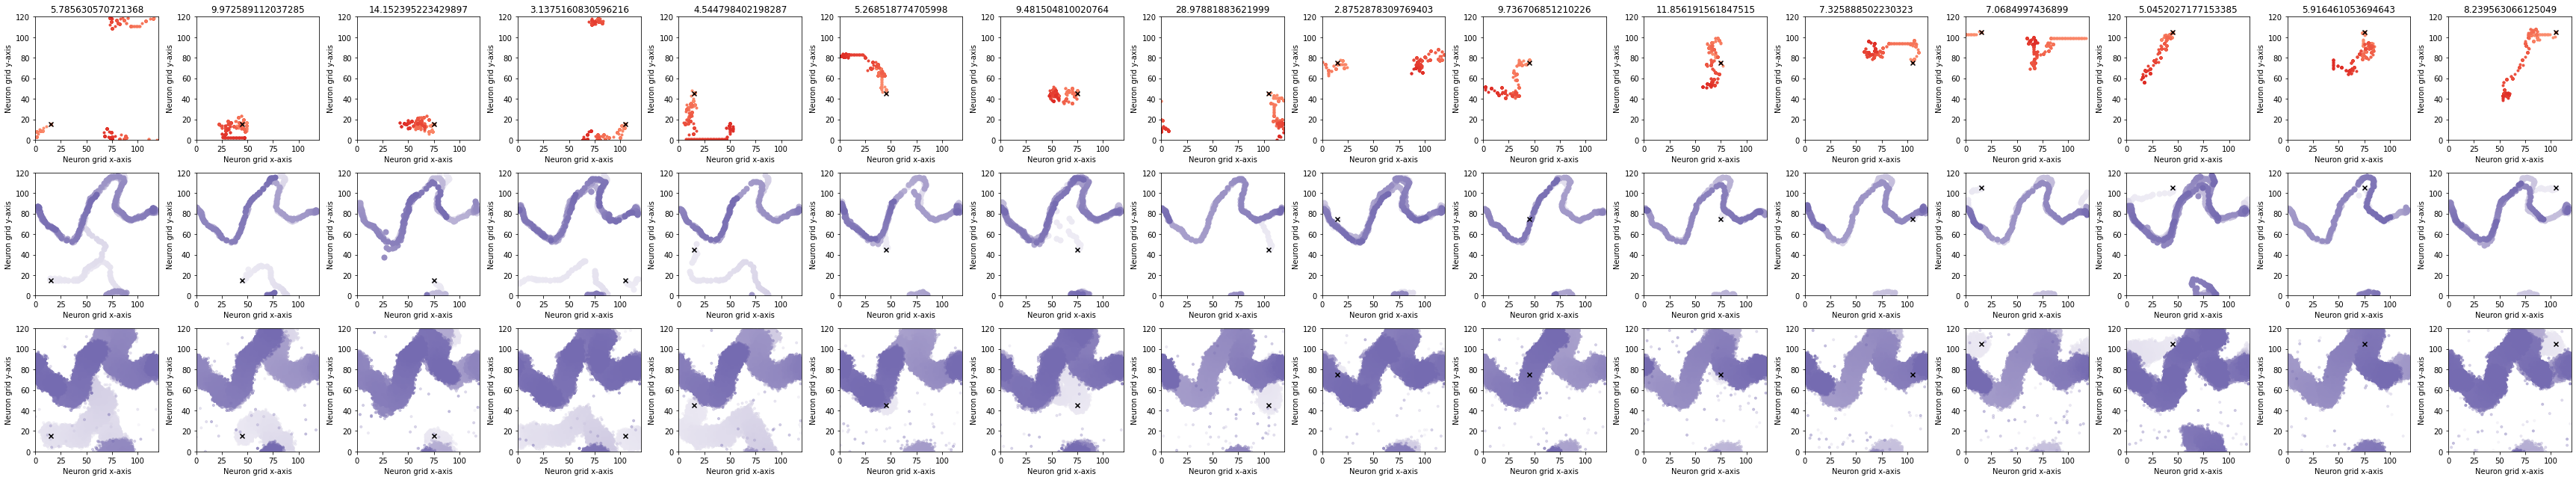

In [17]:
# Calculate FFN - one neuron + area, 1st, 2nd and 3rd order excitatory connections
# run for multiple points script

# --- choose starting point
#start_N_all = [[30,30],[30,60],[30,90],[60,30],[60,60],[60,90],[90,30],[90,60],[90,90]]
start_N_all = [[15,15], [15,45], [15,75], [15,105], [45,15], [45,45], [45,75], [45,105], [75,15], [75,45], [75,75], [75,105], [105,15], [105,45], [105,75], [105,105]]
#start_N_all = [[15,15], [15,45], [15,75], [15,105]]

at = 0
area_typ = 'circle'

n_steps = 500
dc_scale = 10
wmin = 5

path_label = ['initial','final']
fig, ax = plt.subplots(3, len(start_N_all), figsize=[3*len(start_N_all), 9])
dist_all = np.zeros(len(start_N_all))

for i1, wmaj in enumerate([10]): #range that works normally - 8 to 14
    for i2, dc_off in enumerate([0.1]):
        for i3, dc_scale in enumerate([1]):
            for sN,start_N in enumerate(start_N_all):

                cm = [list(Color("#efedf5").range_to(Color("#756bb1"), int(n_steps + 1))), list(Color("#fc9272").range_to(Color("#de2d26"), int(n_steps + 1)))]

                for at,area_typ in enumerate(['circle']):
                    
                    print(start_N)
                    
                    sn = i1
                    sn2 = sN
                                        
                    """
                    init_grid_ax(nrowE, ncolE, ax[sn,2*at])
                    for j,p in enumerate(path):
                        ax[sn,2*at].scatter(p[1], p[0], c=[cm[1][j].rgb], marker='.')            
                    ax[sn,2*at].scatter(path[0][1], path[0][0], c='black', marker='x')
                    """
                    #if sn == 0 and sn2 == 0:
                    address = '/shreya/data/EI_dynamic_input_{}/EI_{}_poke2_size3_std4-6-4-6_g8_J10_nmbE275I275p850_base{}_{}-{}-8_trial{}/'.format(asymm, asymm, base, start_N[1], start_N[0], 0)            
                    #address = '/shreya/data/EI_dynamic_input_{}/EI_{}_size3_std4-6-4-6_g8_J10_nmbE250I250p200_base{}_{}-{}-8/'.format(asymm, asymm, base, start_N[1], start_N[0])
                    c = ["#efedf5", "#756bb1"]
                    e = False
                    init_grid_ax(nrowE, ncolE, ax[sn,2*at+1])
                    print(address)
                    ts, ids = pf.get_spiketimes(address, 4)
                    idx = ids < 14401
                    tsE, idsE = ts[idx], ids[idx]
                    init_grid_ax(nrowE, ncolE, ax[2,sn2])
                    FR_time = arrange_FR_on_grid_seq(tsE, idsE, 200.,np.max(tsE),10., ax[2, sn2], c, e)
                    del([ts, ids, tsE, idsE, idx])

                    activity_path, goes_out = get_centroids_activity_path(FR_time, nrowE, ncolE, start_N)
                    cm1 = list(Color("#efedf5").range_to(Color("#756bb1"), int(np.shape(activity_path)[0] + 1)))
                    
                    if goes_out == False:
                        print("Activity does not go out!")
                        continue
                                   
                    
                    init_grid_ax(nrowE, ncolE, ax[1,sn2])
                    for j,p in enumerate(activity_path):
                        if j == 0:
                            ax[1,sn2].scatter(p[1], p[0], c=[cm1[j].rgb], marker='o',s=50, label=path_label[0]) 
                        elif j == len(activity_path)-1:
                            ax[1,sn2].scatter(p[1], p[0], c=[cm1[j].rgb], marker='o',s=50, label=path_label[1]) 
                        else:
                            ax[1,sn2].scatter(p[1], p[0], c=[cm1[j].rgb], marker='o',s=50)
                    
                        
                    
                    path = [start_N]
                    
                    # initial theta
                    theta = np.mean(vEE_all[(start_N[0]-4)%nrowE:(start_N[0]+4)%nrowE, (start_N[1]-4)%nrowE:(start_N[1]+4)%nrowE, 1])
                    
                    for i in range(n_steps):
            
                        #Evector1 = exc_vectors[start_N[0], start_N[1],:].tolist()
                        #params = [wmaj, wmin, dc_off, dc_scale]
                        #params = [w, dc_off, dc_scale]
                        #Evector = get_surround_avg(start_N, exc_vectors, area_typ, params, theta)   
                        
                        if area_typ == 'circle':
                            surround_points = get_points_in_circle(start_N, wmaj)
                        elif area_typ == 'ellipse':
                            surround_points = get_points_in_ellipse(start_N, wmaj, wmin, theta)

                        all_vE = []
                        #print(np.shape(surround_points))
                        for _i in range(np.shape(surround_points)[0]):
                            _xsn, _ysn = surround_points[_i, 0], surround_points[_i, 1]
                            all_vec_p = [vEE_all[_xsn, _ysn, :], vEEE_all[_xsn, _ysn, :], reverse_vector(vEIE_all[_xsn, _ysn, :]), vEEEE_all[_xsn, _ysn, :], vEIIE_all[_xsn, _ysn, :], reverse_vector(vEIEE_all[_xsn, _ysn, :]), reverse_vector(vEEIE_all[_xsn, _ysn, :])]
                            net_vE = get_sum(all_vec_p, nrowE, ncolE)
                            #net_vE = get_sum([vEE_all[_xsn, _ysn, :], vEEE_all[_xsn, _ysn, :], reverse_vector(vEIE_all[_xsn, _ysn, :])], nrowE, ncolE)
                            dc = dc_scale / (np.sqrt((start_N[0] - _xsn)**2 + (start_N[1] - _ysn)**2) + dc_off)
                            #dc = 1
                            l_scale = net_vE[0] * dc
                            net_vE = [l_scale, net_vE[1]]
                            all_vE.append(net_vE)
                        net_vE_all = get_mean(all_vE, nrowE, ncolE)
                        [start_N] = get_ends_EtoE(net_vE_all, start_N, nrowE, ncolE)        
                        #EIvector = get_sum(EIvectors, nrowE, ncolE)
                        if area_typ == 'ellipse':
                            theta = get_sum([[1,theta], [2,net_vE[1]]], nrowE, ncolE)
                            theta = theta[1]
                                        
                        #start_N = get_ends([EIvector], start_N, nrowE, ncolE)[0]
                        last_path = path[-20:]
                        last_N = []
                        for lN in last_path:
                            last_N += lN
                        if i > 20 and len(np.unique(last_N)) < 6:
                            print("loop found at step {}, choosing another neuron in neighbourhood".format(i))
                            sample_list = get_neighbours(start_N, 8, nrowE, ncolE, last_N)
                            start_N = sample_list[np.random.choice(len(sample_list))]
                        
                        path.append(start_N)
                                
                    print("Done.")

                    init_grid_ax(nrowE, ncolE, ax[sn,sn2])
                    for j,p in enumerate(path):
                        ax[sn,sn2].scatter(p[1], p[0], c=[cm[1][j].rgb], marker='.')            
                    
                    ax[0,sn2].scatter(path[0][1], path[0][0], c='black', marker='x')
                    ax[1,sn2].scatter(path[0][1], path[0][0], c='black', marker='x')
                    ax[2,sn2].scatter(path[0][1], path[0][0], c='black', marker='x')
                    #ax[sn,sn2].set_title("{},{}".format(wmaj,wmin))
                    
                    d = get_distance(np.array(path), activity_path)
                    ax[sn,sn2].set_title(str(d))
                    dist_all[sN] = d
                    print(d)

print(dist_all)
plt.tight_layout()
plt.show()

In [ ]:
# working EI

for i in range(n_steps):
    #Evector1 = exc_vectors[start_N[0], start_N[1],:].tolist()
    params = params_all[at]
    Evector = get_surround_avg(start_N, exc_vectors, area_typ, params, theta)
    #Evector = get_surround_avg(start_N, exc_vectors, area_typ)
    endpoints = get_ends([Evector], start_N, nrowE, ncolE)
    EIvectors = []
    for e in endpoints:
        Ivector = inh_vectors[e[0],e[1],:].tolist()
        EIv = get_sum([Evector, reverse_vector(Ivector)], nrowE, ncolE)
        EIvectors.append(EIv)
    EIvector = get_sum(EIvectors, nrowE, ncolE)
    if at == 1:
        theta = get_sum([[1,theta], [3,EIvector[1]]], nrowE, ncolE)
        start_N = get_ends([theta], start_N, nrowE, ncolE)[0]
        theta = theta[1]
    else:
        start_N = get_ends([EIvector], start_N, nrowE, ncolE)[0]
    last_path = path[-20:]
    last_N = []
    for lN in last_path:
        last_N += lN
    if i > 20 and len(np.unique(last_N)) < 6:
        print("loop found at step {}, choosing another neuron in neighbourhood".format(i))
        sample_list = get_neighbours(start_N, 8, nrowE, ncolE, last_N)
        start_N = sample_list[np.random.choice(len(sample_list))]
    path.append(start_N)  

In [13]:
# Model 2 
# Load the landscape

nrowE = ncolE = 120
nrowI = ncolI = 60
nE = nrowE * ncolE
nI = nrowI * ncolI
nN = nE + nI

# --- asymmetry parameters
asymm = 'EE'
landscape_type = 'perlinuniform'
landscape_size = 3
base = 0
[pEE, pEI, pIE, pII] = [0.05, 0.05, 0.05, 0.05]
[stdEE, stdEI, stdIE, stdII] = [7, 9, 7, 9]

# --- read the landscape file
address = '/shreya/AM_all/'
vec_address = '/shreya/vec_all/'
fname = 'size3_EE_perlinuniform_std7.0-9.0-7.0-9.0_p0.05-0.05-0.05-0.05_alpha0.1_sep2.0_width10.0_base0_landscape.npz'
#fname = '{}size{}_{}_perlinuniform_std4.0-6.0-4.0-6.0_p0.05-0.05-0.05-0.05_shift1.0_base{}landscape.npz'

landscape = sparse.load_npz(address + fname).toarray()
nrowL = int(np.sqrt(np.size(landscape)))
landscape = landscape.reshape((nrowL, nrowL))

#fname = '{}size{}_{}_perlinuniform_std7.0-9.0-7.0-9.0_p0.05-0.05-0.05-0.05_alpha0.1_sep2.0_width10.0_base{}_landscape.npz'
#fname2 = '{}size{}_{}_perlinuniform_std7.0-9.0-7.0-9.0_p0.05-0.05-0.05-0.05_alpha0.1_sep2.0_width10.0_base{}_{}.npy'
fname = '{}size{}_{}_perlinuniform_std4.0-6.0-4.0-6.0_p0.05-0.05-0.05-0.05_shift1.0_base{}landscape.npz'
fname2 = '{}size{}_{}_perlinuniform_std4.0-6.0-4.0-6.0_p0.05-0.05-0.05-0.05_shift1.0_base{}_{}.npy'
vEE_all, vEEE_all, vEIE_all, vEEEE_all, vEEIE_all, vEIEE_all, vEIIE_all = nFF2.read_or_get_vec(fname, fname2, address, vec_address, landscape_size, asymm, base, [nrowE, ncolE, nrowI, ncolI])

First order connections read.
Second order connections read.
Second order connections read.
Third order connections read.
Third order connections read.
Third order connections read.
Third order connections read.


[75, 45]
/media/shreya/Kamlesh/shreya/data/EI_dynamic_input_model2_EE/EI_EE_size3_std7-9-7-9_g10g21J10_nmbE290I290p800_w10a0.1sep2_45-75-8_base0_trial0/
4
Done.
[(501, 2), (332, 2)]
1.9767477375085172
[75, 45]
loop found at step 21, choosing another neuron in neighbourhood
loop found at step 22, choosing another neuron in neighbourhood
loop found at step 41, choosing another neuron in neighbourhood
loop found at step 42, choosing another neuron in neighbourhood
loop found at step 61, choosing another neuron in neighbourhood
loop found at step 62, choosing another neuron in neighbourhood
loop found at step 81, choosing another neuron in neighbourhood
loop found at step 82, choosing another neuron in neighbourhood
loop found at step 101, choosing another neuron in neighbourhood
loop found at step 102, choosing another neuron in neighbourhood
loop found at step 121, choosing another neuron in neighbourhood
loop found at step 122, choosing another neuron in neighbourhood
loop found at step

loop found at step 281, choosing another neuron in neighbourhood
loop found at step 282, choosing another neuron in neighbourhood
loop found at step 301, choosing another neuron in neighbourhood
loop found at step 302, choosing another neuron in neighbourhood
loop found at step 321, choosing another neuron in neighbourhood
loop found at step 322, choosing another neuron in neighbourhood
loop found at step 341, choosing another neuron in neighbourhood
loop found at step 342, choosing another neuron in neighbourhood
loop found at step 343, choosing another neuron in neighbourhood
loop found at step 361, choosing another neuron in neighbourhood
loop found at step 362, choosing another neuron in neighbourhood
loop found at step 381, choosing another neuron in neighbourhood
loop found at step 382, choosing another neuron in neighbourhood
loop found at step 401, choosing another neuron in neighbourhood
loop found at step 402, choosing another neuron in neighbourhood
loop found at step 403, c

loop found at step 461, choosing another neuron in neighbourhood
loop found at step 462, choosing another neuron in neighbourhood
loop found at step 481, choosing another neuron in neighbourhood
loop found at step 482, choosing another neuron in neighbourhood
Done.
[(501, 2), (332, 2)]
13.008678205750805
[75, 45]
loop found at step 46, choosing another neuron in neighbourhood
loop found at step 83, choosing another neuron in neighbourhood
loop found at step 121, choosing another neuron in neighbourhood
loop found at step 153, choosing another neuron in neighbourhood
loop found at step 191, choosing another neuron in neighbourhood
loop found at step 234, choosing another neuron in neighbourhood
loop found at step 268, choosing another neuron in neighbourhood
Done.
[(501, 2), (332, 2)]
3.863594112658878
[75, 45]
Done.
[(501, 2), (332, 2)]
2.470543782818349
[75, 45]
loop found at step 21, choosing another neuron in neighbourhood
loop found at step 22, choosing another neuron in neighbourh

loop found at step 292, choosing another neuron in neighbourhood
loop found at step 293, choosing another neuron in neighbourhood
loop found at step 329, choosing another neuron in neighbourhood
loop found at step 330, choosing another neuron in neighbourhood
loop found at step 370, choosing another neuron in neighbourhood
loop found at step 407, choosing another neuron in neighbourhood
loop found at step 409, choosing another neuron in neighbourhood
loop found at step 463, choosing another neuron in neighbourhood
loop found at step 464, choosing another neuron in neighbourhood
loop found at step 483, choosing another neuron in neighbourhood
loop found at step 484, choosing another neuron in neighbourhood
Done.
[(501, 2), (332, 2)]
6.868095389809495
[75, 45]
loop found at step 21, choosing another neuron in neighbourhood
loop found at step 22, choosing another neuron in neighbourhood
loop found at step 41, choosing another neuron in neighbourhood
loop found at step 42, choosing another

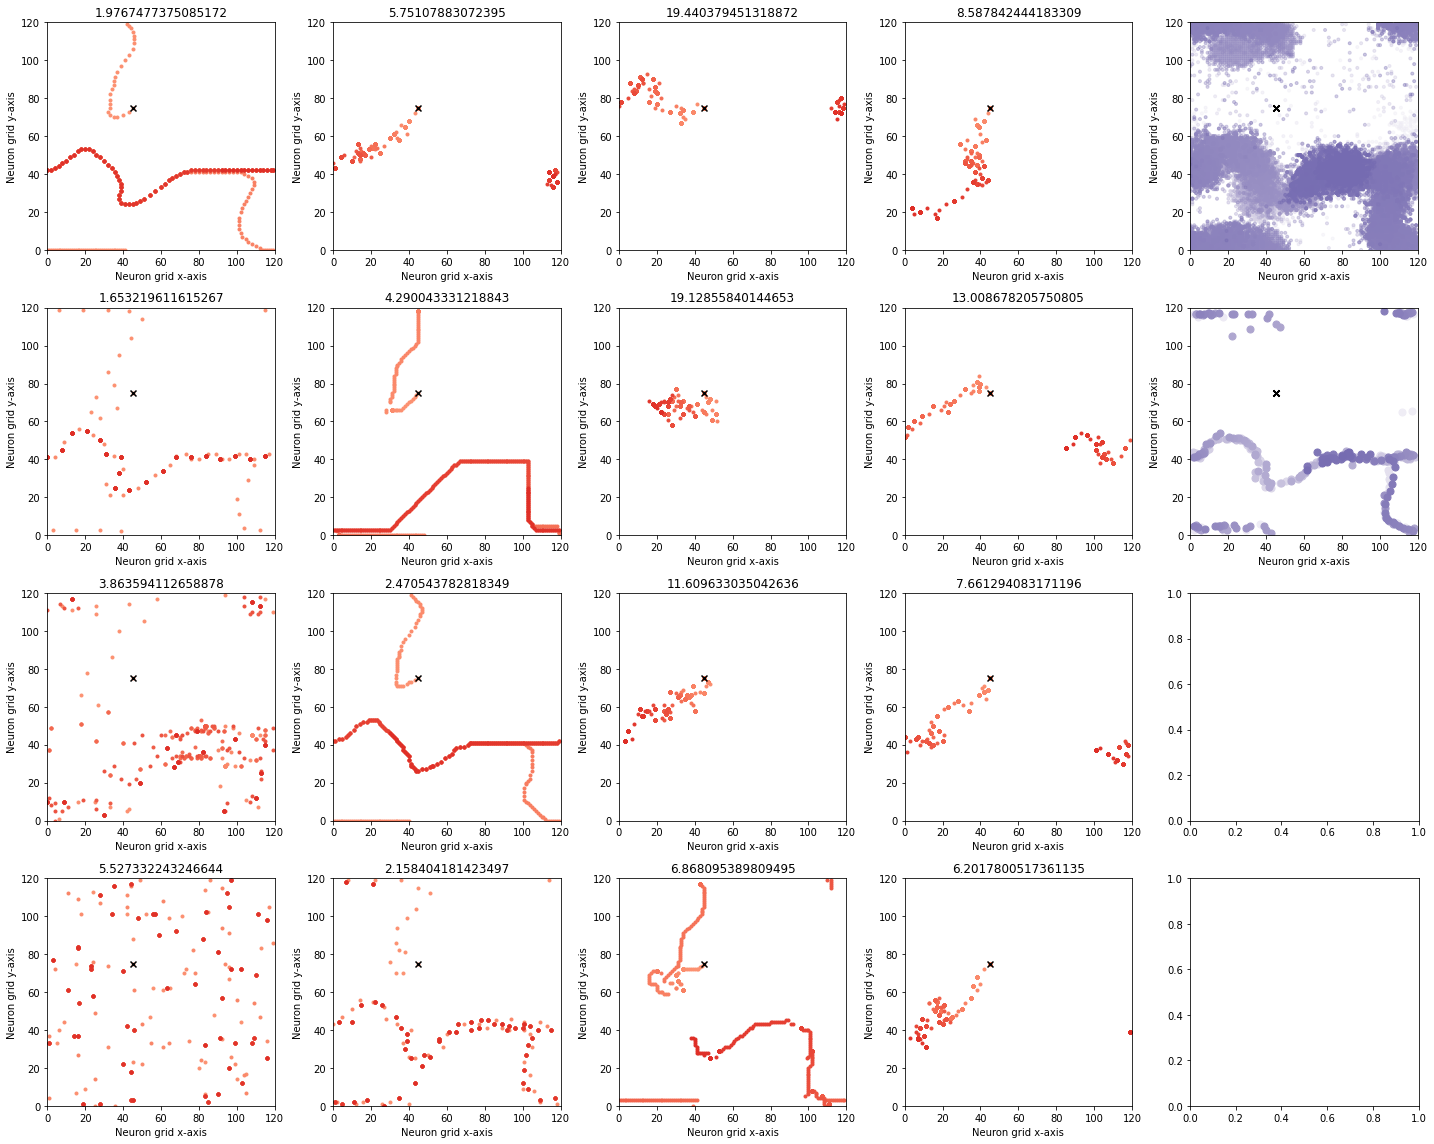

In [17]:
# Model 2
# Calculate FFN - one neuron + area, 1st, 2nd and 3rd order excitatory connections
# testing params script

# --- choose starting point


#start_N_all = [[15,15], [15,45], [15,75], [15,105], [45,15], [45,45], [45,75], [45,105], [75,15], [75,45], [75,75], [75,105], [105,15], [105,45], [105,75], [105,105]]
start_N_all = [[75,45]]#, [15,45], [15,75], [15,105], [45,15], [45,45], [45,75], [45,105], [75,15], [75,45], [75,75], [75,105], [105,15], [105,45], [105,75], [105,105]]

at = 0
area_typ = 'circle'

n_steps = 500
dc_scale = 1
wmin = 3

path_label = ['initial','final']
fig, ax = plt.subplots(4,5, figsize=[20,16])
dist_all = np.zeros((4,4))

for i1, wmaj in enumerate([10]): #range that works normally - 8 to 14
    for i2, dc_off in enumerate([10, 1, 0.1, 0.01]):
        for i3, dc_scale in enumerate([10, 1, 0.1, 0.01]):
            for sN,start_N in enumerate(start_N_all):

                cm = [list(Color("#efedf5").range_to(Color("#756bb1"), int(n_steps + 1))), list(Color("#fc9272").range_to(Color("#de2d26"), int(n_steps + 1)))]

                for at,area_typ in enumerate(['circle']):
                    
                    print(start_N)
                    
                    sn = i2
                    sn2 = i3
                                        
                    """
                    init_grid_ax(nrowE, ncolE, ax[sn,2*at])
                    for j,p in enumerate(path):
                        ax[sn,2*at].scatter(p[1], p[0], c=[cm[1][j].rgb], marker='.')            
                    ax[sn,2*at].scatter(path[0][1], path[0][0], c='black', marker='x')
                    """
                    if sn == 0 and sn2 == 0:
                        address = '/media/shreya/Kamlesh/shreya/data/EI_dynamic_input_model2_{}/EI_{}_size3_std7-9-7-9_g10g21J10_nmbE290I290p800_w10a0.1sep2_{}-{}-8_base{}_trial0/'.format(asymm, asymm, start_N[1], start_N[0], base)
                        c = ["#efedf5", "#756bb1"]
                        e = True
                        init_grid_ax(nrowE, ncolE, ax[sn,2*at+1])
                        print(address)
                        ts, ids = pf.get_spiketimes(address, 4)
                        idx = ids < 14401
                        tsE, idsE = ts[idx], ids[idx]
                        init_grid_ax(nrowE, ncolE, ax[0,4])
                        FR_time = arrange_FR_on_grid_seq(tsE, idsE, 200.,np.max(tsE),10., ax[0, 4], c, e)
                        del([ts, ids, tsE, idsE, idx])

                        activity_path, goes_out = get_centroids_activity_path(FR_time, nrowE, ncolE, start_N)
                        cm1 = list(Color("#efedf5").range_to(Color("#756bb1"), int(np.shape(activity_path)[0] + 1)))

                        if goes_out == False:
                            print("Activity does not go out!")
                            continue


                        init_grid_ax(nrowE, ncolE, ax[1,4])
                        for j,p in enumerate(activity_path):
                            if j == 0:
                                ax[1,4].scatter(p[1], p[0], c=[cm1[j].rgb], marker='o',s=50, label=path_label[0]) 
                            elif j == len(activity_path)-1:
                                ax[1,4].scatter(p[1], p[0], c=[cm1[j].rgb], marker='o',s=50, label=path_label[1]) 
                            else:
                                ax[1,4].scatter(p[1], p[0], c=[cm1[j].rgb], marker='o',s=50)                      
                    
                    path = [start_N]
                    
                    # initial theta
                    theta = np.mean(vEE_all[(start_N[0]-4)%nrowE:(start_N[0]+4)%nrowE, (start_N[1]-4)%nrowE:(start_N[1]+4)%nrowE, 1])
                    
                    for i in range(n_steps):
            
                        #Evector1 = exc_vectors[start_N[0], start_N[1],:].tolist()
                        #params = [wmaj, wmin, dc_off, dc_scale]
                        #params = [w, dc_off, dc_scale]
                        #Evector = get_surround_avg(start_N, exc_vectors, area_typ, params, theta)   
                        
                        if area_typ == 'circle':
                            surround_points = get_points_in_circle(start_N, wmaj)
                        elif area_typ == 'ellipse':
                            surround_points = get_points_in_ellipse(start_N, wmaj, wmin, theta)

                        all_vE = []
                        #print(np.shape(surround_points))
                        for _i in range(np.shape(surround_points)[0]):
                            _xsn, _ysn = surround_points[_i, 0], surround_points[_i, 1]
                            all_vec_p = [vEE_all[_xsn, _ysn, :], vEEE_all[_xsn, _ysn, :], reverse_vector(vEIE_all[_xsn, _ysn, :]), vEEEE_all[_xsn, _ysn, :], vEIIE_all[_xsn, _ysn, :], reverse_vector(vEIEE_all[_xsn, _ysn, :]), reverse_vector(vEEIE_all[_xsn, _ysn, :])]
                            net_vE = get_sum(all_vec_p, nrowE, ncolE)
                            #net_vE = get_sum([vEE_all[_xsn, _ysn, :], vEEE_all[_xsn, _ysn, :], reverse_vector(vEIE_all[_xsn, _ysn, :])], nrowE, ncolE)
                            dc = dc_scale / (np.sqrt((start_N[0] - _xsn)**2 + (start_N[1] - _ysn)**2) + dc_off)
                            #dc = 1
                            l_scale = net_vE[0] * dc
                            net_vE = [l_scale, net_vE[1]]
                            all_vE.append(net_vE)
                        net_vE_all = get_mean(all_vE, nrowE, ncolE)
                        [start_N] = nFF2.get_ends_EtoE(net_vE_all, start_N, nrowE, ncolE)        
                        #EIvector = get_sum(EIvectors, nrowE, ncolE)
                        if area_typ == 'ellipse':
                            theta = get_sum([[3,theta], [1,net_vE_all[1]]], nrowE, ncolE)
                            theta = theta[1]
                                        
                        #start_N = get_ends([EIvector], start_N, nrowE, ncolE)[0]
                        last_path = path[-20:]
                        last_N = []
                        for lN in last_path:
                            last_N += lN
                        if i > 20 and len(np.unique(last_N)) < 6:
                            print("loop found at step {}, choosing another neuron in neighbourhood".format(i))
                            sample_list = get_neighbours(start_N, 8, nrowE, ncolE, last_N)
                            start_N = sample_list[np.random.choice(len(sample_list))]
                        
                        path.append(start_N)
                                
                    print("Done.")

                    init_grid_ax(nrowE, ncolE, ax[sn,sn2])
                    for j,p in enumerate(path):
                        ax[sn,sn2].scatter(p[1], p[0], c=[cm[1][j].rgb], marker='.')            
                    
                    ax[sn,sn2].scatter(path[0][1], path[0][0], c='black', marker='x')
                    ax[0,4].scatter(path[0][1], path[0][0], c='black', marker='x')
                    ax[1,4].scatter(path[0][1], path[0][0], c='black', marker='x')
                    #ax[sn,sn2].set_title("{},{}".format(wmaj,wmin))
                    
                    d = get_distance(np.array(path), activity_path)
                    dist_all[sn,sn2] = d
                    ax[sn,sn2].set_title(str(d))
                    print(d)
print(dist_all)                  
plt.tight_layout()
plt.show()

[15, 15]
/media/shreya/Kamlesh/shreya/data/EI_dynamic_input_model2_EE/EI_EE_size3_std7-9-7-9_g10g21J10_nmbE290I290p900_w10a0.1sep2_15-15-8_base0_trial0/
4
Activity does not go out!
[15, 45]
/media/shreya/Kamlesh/shreya/data/EI_dynamic_input_model2_EE/EI_EE_size3_std7-9-7-9_g10g21J10_nmbE290I290p900_w10a0.1sep2_45-15-8_base0_trial0/
4
Activity does not go out!
[15, 75]
/media/shreya/Kamlesh/shreya/data/EI_dynamic_input_model2_EE/EI_EE_size3_std7-9-7-9_g10g21J10_nmbE290I290p900_w10a0.1sep2_75-15-8_base0_trial0/
4
Done.
[(501, 2), (25, 2)]
14.35736380434747
[15, 105]
/media/shreya/Kamlesh/shreya/data/EI_dynamic_input_model2_EE/EI_EE_size3_std7-9-7-9_g10g21J10_nmbE290I290p900_w10a0.1sep2_105-15-8_base0_trial0/
4
Done.
[(501, 2), (48, 2)]
6.371858400721266
[45, 15]
/media/shreya/Kamlesh/shreya/data/EI_dynamic_input_model2_EE/EI_EE_size3_std7-9-7-9_g10g21J10_nmbE290I290p900_w10a0.1sep2_15-45-8_base0_trial0/
4
Done.
[(501, 2), (25, 2)]
17.808981671965586
[45, 45]
/media/shreya/Kamlesh/shreya/

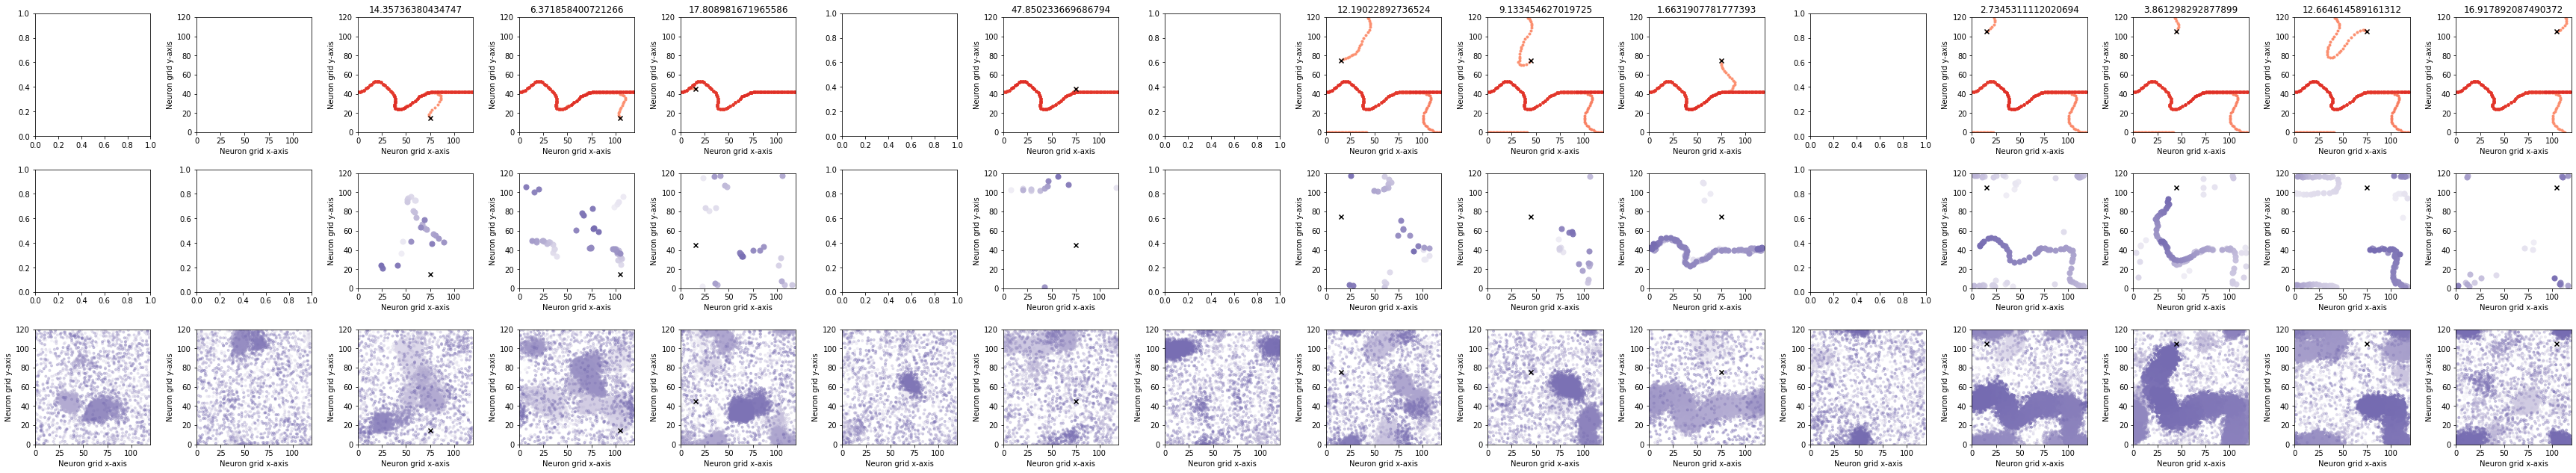

In [25]:
# Model 2
# Calculate FFN - one neuron + area, 1st, 2nd and 3rd order excitatory connections
# run for multiple points script

# --- choose starting point
#start_N_all = [[30,30],[30,60],[30,90],[60,30],[60,60],[60,90],[90,30],[90,60],[90,90]]
start_N_all = [[15,15], [15,45], [15,75], [15,105], [45,15], [45,45], [45,75], [45,105], [75,15], [75,45], [75,75], [75,105], [105,15], [105,45], [105,75], [105,105]]
#start_N_all = [[15,15], [15,45], [15,75], [15,105]]

at = 0
area_typ = 'circle'

n_steps = 500
dc_scale = 10
wmin = 5

path_label = ['initial','final']
fig, ax = plt.subplots(3, len(start_N_all), figsize=[3*len(start_N_all), 9])
dist_all = np.zeros(len(start_N_all))

for i1, wmaj in enumerate([10]): #range that works normally - 8 to 14
    for i2, dc_off in enumerate([10]):
        for i3, dc_scale in enumerate([10]):
            for sN,start_N in enumerate(start_N_all):

                cm = [list(Color("#efedf5").range_to(Color("#756bb1"), int(n_steps + 1))), list(Color("#fc9272").range_to(Color("#de2d26"), int(n_steps + 1)))]

                for at,area_typ in enumerate(['circle']):
                    
                    print(start_N)
                    
                    sn = i1
                    sn2 = sN
                                        
                    """
                    init_grid_ax(nrowE, ncolE, ax[sn,2*at])
                    for j,p in enumerate(path):
                        ax[sn,2*at].scatter(p[1], p[0], c=[cm[1][j].rgb], marker='.')            
                    ax[sn,2*at].scatter(path[0][1], path[0][0], c='black', marker='x')
                    """
                    #if sn == 0 and sn2 == 0:
                    address = '/media/shreya/Kamlesh/shreya/data/EI_dynamic_input_model2_{}/EI_{}_size3_std7-9-7-9_g10g21J10_nmbE290I290p900_w10a0.1sep2_{}-{}-8_base{}_trial0/'.format(asymm, asymm, start_N[1], start_N[0], base)
                    c = ["#efedf5", "#756bb1"]
                    e = False
                    init_grid_ax(nrowE, ncolE, ax[sn,2*at+1])
                    print(address)
                    ts, ids = pf.get_spiketimes(address, 4)
                    idx = ids < 14401
                    tsE, idsE = ts[idx], ids[idx]
                    init_grid_ax(nrowE, ncolE, ax[2,sn2])
                    FR_time = arrange_FR_on_grid_seq(tsE, idsE, 200.,np.max(tsE),10., ax[2, sn2], c, e)
                    del([ts, ids, tsE, idsE, idx])

                    activity_path, goes_out = get_centroids_activity_path(FR_time, nrowE, ncolE, start_N)
                    cm1 = list(Color("#efedf5").range_to(Color("#756bb1"), int(np.shape(activity_path)[0] + 1)))
                    
                    if goes_out == False:
                        print("Activity does not go out!")
                        continue
                                   
                    
                    init_grid_ax(nrowE, ncolE, ax[1,sn2])
                    for j,p in enumerate(activity_path):
                        if j == 0:
                            ax[1,sn2].scatter(p[1], p[0], c=[cm1[j].rgb], marker='o',s=50, label=path_label[0]) 
                        elif j == len(activity_path)-1:
                            ax[1,sn2].scatter(p[1], p[0], c=[cm1[j].rgb], marker='o',s=50, label=path_label[1]) 
                        else:
                            ax[1,sn2].scatter(p[1], p[0], c=[cm1[j].rgb], marker='o',s=50)
                    
                        
                    
                    path = [start_N]
                    
                    # initial theta
                    theta = np.mean(vEE_all[(start_N[0]-4)%nrowE:(start_N[0]+4)%nrowE, (start_N[1]-4)%nrowE:(start_N[1]+4)%nrowE, 1])
                    
                    for i in range(n_steps):
            
                        #Evector1 = exc_vectors[start_N[0], start_N[1],:].tolist()
                        #params = [wmaj, wmin, dc_off, dc_scale]
                        #params = [w, dc_off, dc_scale]
                        #Evector = get_surround_avg(start_N, exc_vectors, area_typ, params, theta)   
                        
                        if area_typ == 'circle':
                            surround_points = get_points_in_circle(start_N, wmaj)
                        elif area_typ == 'ellipse':
                            surround_points = get_points_in_ellipse(start_N, wmaj, wmin, theta)

                        all_vE = []
                        #print(np.shape(surround_points))
                        for _i in range(np.shape(surround_points)[0]):
                            _xsn, _ysn = surround_points[_i, 0], surround_points[_i, 1]
                            all_vec_p = [vEE_all[_xsn, _ysn, :], vEEE_all[_xsn, _ysn, :], reverse_vector(vEIE_all[_xsn, _ysn, :]), vEEEE_all[_xsn, _ysn, :], vEIIE_all[_xsn, _ysn, :], reverse_vector(vEIEE_all[_xsn, _ysn, :]), reverse_vector(vEEIE_all[_xsn, _ysn, :])]
                            net_vE = get_sum(all_vec_p, nrowE, ncolE)
                            #net_vE = get_sum([vEE_all[_xsn, _ysn, :], vEEE_all[_xsn, _ysn, :], reverse_vector(vEIE_all[_xsn, _ysn, :])], nrowE, ncolE)
                            dc = dc_scale / (np.sqrt((start_N[0] - _xsn)**2 + (start_N[1] - _ysn)**2) + dc_off)
                            #dc = 1
                            l_scale = net_vE[0] * dc
                            net_vE = [l_scale, net_vE[1]]
                            all_vE.append(net_vE)
                        net_vE_all = get_mean(all_vE, nrowE, ncolE)
                        [start_N] = get_ends_EtoE(net_vE_all, start_N, nrowE, ncolE)        
                        #EIvector = get_sum(EIvectors, nrowE, ncolE)
                        if area_typ == 'ellipse':
                            theta = get_sum([[1,theta], [2,net_vE[1]]], nrowE, ncolE)
                            theta = theta[1]
                                        
                        #start_N = get_ends([EIvector], start_N, nrowE, ncolE)[0]
                        last_path = path[-20:]
                        last_N = []
                        for lN in last_path:
                            last_N += lN
                        if i > 20 and len(np.unique(last_N)) < 6:
                            print("loop found at step {}, choosing another neuron in neighbourhood".format(i))
                            sample_list = get_neighbours(start_N, 8, nrowE, ncolE, last_N)
                            start_N = sample_list[np.random.choice(len(sample_list))]
                        
                        path.append(start_N)
                                
                    print("Done.")

                    init_grid_ax(nrowE, ncolE, ax[sn,sn2])
                    for j,p in enumerate(path):
                        ax[sn,sn2].scatter(p[1], p[0], c=[cm[1][j].rgb], marker='.')            
                    
                    ax[0,sn2].scatter(path[0][1], path[0][0], c='black', marker='x')
                    ax[1,sn2].scatter(path[0][1], path[0][0], c='black', marker='x')
                    ax[2,sn2].scatter(path[0][1], path[0][0], c='black', marker='x')
                    #ax[sn,sn2].set_title("{},{}".format(wmaj,wmin))
                    
                    d = get_distance(np.array(path), activity_path)
                    ax[sn,sn2].set_title(str(d))
                    dist_all[sN] = d
                    print(d)

nmp = 900
print(dist_all)
np.save('/home/shreya/work/notes/newFFN2_results2/m2_{}_all_w{}off{}sc{}_p{}_base{}_dist.npy'.format(asymm, wmaj, dc_off, dc_scale, nmp, base), dist_all)
plt.tight_layout()
plt.savefig('/home/shreya/work/notes/newFFN2_results2/m2_{}_all_w{}off{}sc{}_p{}_base{}.png'.format(asymm, wmaj, dc_off, dc_scale, nmp, base))
plt.show()